In [1]:
# Code originally written on kaggle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

print(f"PyTorch version: {torch.__version__}")

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

if not os.path.exists('results'):
    os.makedirs('results')

def print_gpu_info():
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
        print(f"Memory cached: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
    else:
        print("No GPU available, using CPU")

print_gpu_info()

Using device: cuda
PyTorch version: 2.5.1+cu121
GPU: Tesla T4
Memory allocated: 0.00 GB
Memory cached: 0.00 GB


In [2]:
file_path = '/kaggle/input/quark-gluon/quark-gluon_data-set_n139306.hdf5'

with h5py.File(file_path, 'r') as f:
    print("Keys in the HDF5 file:")
    keys = list(f.keys())
    print(keys) 

    for key in keys:
        dataset = f[key]
        print(f"\nDataset: '{key}'")
        print(f"  Shape: {dataset.shape}")
        print(f"  Data Type: {dataset.dtype}")

        # lazy loading
        if dataset.dtype.kind in ['i', 'f']:  # To check if dataset is integer or float
            sample = dataset[:min(1000, dataset.shape[0])]
            print(f"  Min: {np.min(sample)}")
            print(f"  Max: {np.max(sample)}")
            print(f"  Mean: {np.mean(sample)}")

        print("-" * 50)


Keys in the HDF5 file:
['X_jets', 'm0', 'pt', 'y']

Dataset: 'X_jets'
  Shape: (139306, 125, 125, 3)
  Data Type: float32
  Min: 0.0
  Max: 3.8962318897247314
  Mean: 5.227973451837897e-05
--------------------------------------------------

Dataset: 'm0'
  Shape: (139306,)
  Data Type: float32
  Min: 6.30795431137085
  Max: 54.7397346496582
  Mean: 21.079296112060547
--------------------------------------------------

Dataset: 'pt'
  Shape: (139306,)
  Data Type: float32
  Min: 72.45567321777344
  Max: 260.9006652832031
  Mean: 116.5829086303711
--------------------------------------------------

Dataset: 'y'
  Shape: (139306,)
  Data Type: float32
  Min: 0.0
  Max: 1.0
  Mean: 0.5180000066757202
--------------------------------------------------


In [3]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.v2 as transforms

#Load Subset
with h5py.File('/kaggle/input/quark-gluon/quark-gluon_data-set_n139306.hdf5', 'r') as file:
    train_imgs = np.array(file['X_jets'][:8192])  
    test_imgs = np.array(file['X_jets'][8192:8192+2048]) 
    print(f"Train Image Shape: {train_imgs.shape}, Test Image Shape: {test_imgs.shape}")

# Dataset class
class JetImageDataset(Dataset):
    def __init__(self, imgs):
        super().__init__()
        self.transform = transforms.ToTensor()
        self.imgs = imgs  

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.transform(self.imgs[idx])
        img2 = torch.zeros((3, 128, 128), dtype=img.dtype) 
        img2[:, :img.shape[1], :img.shape[2]] = img 
        return img2

#DataLoader
train_dataset = JetImageDataset(train_imgs)
test_dataset = JetImageDataset(test_imgs)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

#Check first batch
x_batch = next(iter(train_loader))
print(f"Train Batch Shape: {x_batch.shape}")


Train Image Shape: (8192, 125, 125, 3), Test Image Shape: (2048, 125, 125, 3)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Train Batch Shape: torch.Size([64, 3, 128, 128])


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Flatten()
        )

        self.h_out = 16
        self.flatten_dim = 256 * self.h_out * self.h_out  # 256*16*16

        self.fc_latent = nn.Linear(self.flatten_dim, latent_dim * 2)

        self.decoder_input = nn.Linear(latent_dim, 256 * 16 * 16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def encode(self, x):
        x = self.encoder(x)
        latent_output = self.fc_latent(x)
        mu, log_var = torch.chunk(latent_output, 2, dim=1)

        # Clamp log_var to stabilize KL divergence
        log_var = torch.clamp(log_var, min=-10, max=2)

        return mu, log_var

    def reparameterize(self, mu, log_var):
        log_var = torch.tanh(log_var) * 2
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, self.h_out, self.h_out)
        return self.decoder(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var


In [7]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt 

def loss_function(recon_x, x, mu, log_var, kl_weight=0.5):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    kl_loss = torch.where(kl_loss > 50, kl_loss * 0.1, kl_loss)  # 🔹 Clamps large KL values

    return recon_loss + kl_weight * kl_loss, recon_loss, kl_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
latent_dim = 64
learning_rate = 0.001
num_epochs = 50
batch_size = 64

# Initialize
vae = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

prev_loss = float('inf')
best_loss = float('inf')

#For plottting
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    vae.train()
    train_loss, train_recon_loss, train_kl_loss = 0, 0, 0

    train_loop = tqdm(train_loader, desc="Training")

    kl_weight = min(1.0, 0.00005 * epoch)

    for data in train_loop:
        data = data.to(device)
        batch_size = data.size(0)

        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, log_var = vae(data)

        # Compute loss
        loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, log_var, kl_weight)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)  # 🔹 Gradient Clipping
        optimizer.step()

        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()

        train_loop.set_postfix(loss=loss.item() / batch_size)

        del data

    # Compute average training loss
    train_loss /= len(train_loader.dataset)
    train_recon_loss /= len(train_loader.dataset)
    train_kl_loss /= len(train_loader.dataset)

    print(f"Training Loss: {train_loss:.4f} (Recon: {train_recon_loss:.4f}, KL: {train_kl_loss:.4f})")

    vae.eval()
    val_loss, val_recon_loss, val_kl_loss = 0, 0, 0

    with torch.no_grad():
        val_loop = tqdm(test_loader, desc="Validation")

        for data in val_loop:
            data = data.to(device)
            batch_size = data.size(0)

            # Forward pass
            recon_batch, mu, log_var = vae(data)

            # Compute loss
            loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, log_var, kl_weight)

            val_loss += loss.item()
            val_recon_loss += recon_loss.item()
            val_kl_loss += kl_loss.item()

            val_loop.set_postfix(loss=loss.item() / batch_size)

            del data

    # Compute average validation loss
    val_loss /= len(test_loader.dataset)
    val_recon_loss /= len(test_loader.dataset)
    val_kl_loss /= len(test_loader.dataset)

    print(f"Validation Loss: {val_loss:.4f} (Recon: {val_recon_loss:.4f}, KL: {val_kl_loss:.4f})")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step()

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(vae.state_dict(), "model.pth")
        print("Model saved.")

    torch.cuda.empty_cache()

print("Training complete")

Using device: cuda

Epoch 1/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.43it/s, loss=0.482] 


Training Loss: 1229.6902 (Recon: 1229.6902, KL: 12783.6965)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.33it/s, loss=0.581]


Validation Loss: 0.7052 (Recon: 0.7052, KL: 4486.7880)
Model saved.

Epoch 2/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.27it/s, loss=0.188]


Training Loss: 0.3285 (Recon: 0.3096, KL: 377.8365)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.28it/s, loss=0.288]


Validation Loss: 0.4254 (Recon: 0.4091, KL: 327.0972)
Model saved.

Epoch 3/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.05it/s, loss=0.198]


Training Loss: 0.2513 (Recon: 0.2455, KL: 58.4670)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.54it/s, loss=0.235]


Validation Loss: 0.3772 (Recon: 0.3707, KL: 65.0814)
Model saved.

Epoch 4/50


Training: 100%|██████████| 128/128 [00:09<00:00, 12.84it/s, loss=0.216]


Training Loss: 0.2359 (Recon: 0.2306, KL: 35.5073)


Validation: 100%|██████████| 32/32 [00:01<00:00, 31.93it/s, loss=0.213]


Validation Loss: 0.3603 (Recon: 0.3546, KL: 37.6371)
Model saved.

Epoch 5/50


Training: 100%|██████████| 128/128 [00:10<00:00, 12.71it/s, loss=0.233]


Training Loss: 0.2148 (Recon: 0.2108, KL: 20.1808)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.43it/s, loss=0.182]


Validation Loss: 0.3499 (Recon: 0.3467, KL: 15.7039)
Model saved.

Epoch 6/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.00it/s, loss=0.148]


Training Loss: 0.2041 (Recon: 0.2004, KL: 14.8056)


Validation: 100%|██████████| 32/32 [00:01<00:00, 31.82it/s, loss=0.156]


Validation Loss: 0.3350 (Recon: 0.3323, KL: 11.0620)
Model saved.

Epoch 7/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.16it/s, loss=0.153]


Training Loss: 0.1926 (Recon: 0.1889, KL: 12.5273)


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.53it/s, loss=0.188]


Validation Loss: 0.3616 (Recon: 0.3436, KL: 59.7437)

Epoch 8/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.23it/s, loss=0.127]


Training Loss: 0.1845 (Recon: 0.1805, KL: 11.3285)


Validation: 100%|██████████| 32/32 [00:01<00:00, 31.07it/s, loss=0.184]


Validation Loss: 0.3510 (Recon: 0.3489, KL: 6.0061)

Epoch 9/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.26it/s, loss=0.15]  


Training Loss: 0.1787 (Recon: 0.1746, KL: 10.2183)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.61it/s, loss=0.16] 


Validation Loss: 0.3396 (Recon: 0.3365, KL: 7.8684)

Epoch 10/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.20it/s, loss=0.163]


Training Loss: 0.1759 (Recon: 0.1717, KL: 9.3428)


Validation: 100%|██████████| 32/32 [00:01<00:00, 31.11it/s, loss=0.241]


Validation Loss: 0.4176 (Recon: 0.3665, KL: 113.4047)

Epoch 11/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.05it/s, loss=0.198] 


Training Loss: 0.1737 (Recon: 0.1693, KL: 8.8539)


Validation: 100%|██████████| 32/32 [00:01<00:00, 31.97it/s, loss=0.144]


Validation Loss: 0.3195 (Recon: 0.3157, KL: 7.5484)
Model saved.

Epoch 12/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.02it/s, loss=0.391]


Training Loss: 0.1702 (Recon: 0.1656, KL: 8.2871)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.57it/s, loss=0.131]


Validation Loss: 0.3173 (Recon: 0.3134, KL: 7.0201)
Model saved.

Epoch 13/50


Training: 100%|██████████| 128/128 [00:09<00:00, 12.99it/s, loss=0.104] 


Training Loss: 0.1663 (Recon: 0.1615, KL: 8.0014)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.58it/s, loss=0.276]


Validation Loss: 0.4515 (Recon: 0.3900, KL: 102.5370)

Epoch 14/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.12it/s, loss=0.107] 


Training Loss: 0.1646 (Recon: 0.1597, KL: 7.4308)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.98it/s, loss=0.268]


Validation Loss: 0.4455 (Recon: 0.3672, KL: 120.4616)

Epoch 15/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.15it/s, loss=0.135] 


Training Loss: 0.1619 (Recon: 0.1570, KL: 7.0441)


Validation: 100%|██████████| 32/32 [00:00<00:00, 33.00it/s, loss=0.134]


Validation Loss: 0.3107 (Recon: 0.3051, KL: 7.9036)
Model saved.

Epoch 16/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.12it/s, loss=0.133] 


Training Loss: 0.1604 (Recon: 0.1552, KL: 6.9330)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.75it/s, loss=0.142]


Validation Loss: 0.3213 (Recon: 0.3150, KL: 8.3109)

Epoch 17/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.17it/s, loss=0.0964]


Training Loss: 0.1580 (Recon: 0.1528, KL: 6.5175)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.78it/s, loss=0.141]


Validation Loss: 0.3190 (Recon: 0.3130, KL: 7.4834)

Epoch 18/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.13it/s, loss=0.12]  


Training Loss: 0.1573 (Recon: 0.1519, KL: 6.3054)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.88it/s, loss=0.398]


Validation Loss: 0.5633 (Recon: 0.3988, KL: 193.5110)

Epoch 19/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.09it/s, loss=0.558] 


Training Loss: 0.1558 (Recon: 0.1503, KL: 6.0904)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.49it/s, loss=0.309]


Validation Loss: 0.4557 (Recon: 0.3743, KL: 90.4582)

Epoch 20/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.15it/s, loss=0.109] 


Training Loss: 0.1537 (Recon: 0.1481, KL: 5.8978)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.06it/s, loss=0.14] 


Validation Loss: 0.3176 (Recon: 0.3109, KL: 7.0856)

Epoch 21/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.09it/s, loss=0.103] 


Training Loss: 0.1526 (Recon: 0.1469, KL: 5.7109)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.48it/s, loss=0.142]


Validation Loss: 0.3231 (Recon: 0.3180, KL: 5.1303)

Epoch 22/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.06it/s, loss=0.0989]


Training Loss: 0.1510 (Recon: 0.1452, KL: 5.5607)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.48it/s, loss=0.134]


Validation Loss: 0.3172 (Recon: 0.3099, KL: 7.0274)

Epoch 23/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.08it/s, loss=0.129] 


Training Loss: 0.1500 (Recon: 0.1440, KL: 5.3884)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.10it/s, loss=0.327]


Validation Loss: 0.4940 (Recon: 0.3820, KL: 101.8711)

Epoch 24/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.08it/s, loss=0.106] 


Training Loss: 0.1486 (Recon: 0.1425, KL: 5.3128)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.49it/s, loss=0.192]


Validation Loss: 0.3492 (Recon: 0.3361, KL: 11.3278)

Epoch 25/50


Training: 100%|██████████| 128/128 [00:09<00:00, 12.92it/s, loss=0.127] 


Training Loss: 0.1475 (Recon: 0.1413, KL: 5.1852)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.44it/s, loss=0.119] 


Validation Loss: 0.2924 (Recon: 0.2846, KL: 6.4743)
Model saved.

Epoch 26/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.06it/s, loss=0.106] 


Training Loss: 0.1463 (Recon: 0.1399, KL: 5.1648)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.24it/s, loss=0.262]


Validation Loss: 0.4209 (Recon: 0.3596, KL: 49.0672)

Epoch 27/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.10it/s, loss=0.0947]


Training Loss: 0.1449 (Recon: 0.1383, KL: 5.0591)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.80it/s, loss=0.477]


Validation Loss: 0.6176 (Recon: 0.3878, KL: 176.8275)

Epoch 28/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.07it/s, loss=0.156] 


Training Loss: 0.1434 (Recon: 0.1369, KL: 4.8744)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.72it/s, loss=0.613]


Validation Loss: 0.7744 (Recon: 0.3993, KL: 277.8454)

Epoch 29/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.13it/s, loss=0.131] 


Training Loss: 0.1422 (Recon: 0.1354, KL: 4.8441)


Validation: 100%|██████████| 32/32 [00:01<00:00, 31.78it/s, loss=0.151]


Validation Loss: 0.3279 (Recon: 0.3231, KL: 3.4294)

Epoch 30/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.13it/s, loss=0.0921]


Training Loss: 0.1409 (Recon: 0.1339, KL: 4.7812)


Validation: 100%|██████████| 32/32 [00:01<00:00, 31.91it/s, loss=0.13] 


Validation Loss: 0.3035 (Recon: 0.2970, KL: 4.4552)

Epoch 31/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.08it/s, loss=0.0913]


Training Loss: 0.1394 (Recon: 0.1323, KL: 4.7273)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.30it/s, loss=0.526]


Validation Loss: 0.6814 (Recon: 0.3845, KL: 197.9050)

Epoch 32/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.12it/s, loss=0.0931]


Training Loss: 0.1367 (Recon: 0.1295, KL: 4.6507)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.07it/s, loss=0.755]


Validation Loss: 0.8908 (Recon: 0.3952, KL: 319.7905)

Epoch 33/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.14it/s, loss=0.112] 


Training Loss: 0.1357 (Recon: 0.1284, KL: 4.5822)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.82it/s, loss=0.125]


Validation Loss: 0.2987 (Recon: 0.2889, KL: 6.0804)

Epoch 34/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.03it/s, loss=0.108] 


Training Loss: 0.1348 (Recon: 0.1273, KL: 4.5691)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.33it/s, loss=0.273]


Validation Loss: 0.4519 (Recon: 0.3785, KL: 44.5002)

Epoch 35/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.10it/s, loss=0.107] 


Training Loss: 0.1340 (Recon: 0.1263, KL: 4.5390)


Validation: 100%|██████████| 32/32 [00:01<00:00, 31.21it/s, loss=0.12] 


Validation Loss: 0.2988 (Recon: 0.2762, KL: 13.2948)

Epoch 36/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.12it/s, loss=0.109] 


Training Loss: 0.1333 (Recon: 0.1256, KL: 4.4016)


Validation: 100%|██████████| 32/32 [00:01<00:00, 31.80it/s, loss=0.142]


Validation Loss: 0.3229 (Recon: 0.3163, KL: 3.7649)

Epoch 37/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.04it/s, loss=0.0855]


Training Loss: 0.1328 (Recon: 0.1249, KL: 4.3607)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.17it/s, loss=0.309]


Validation Loss: 0.4784 (Recon: 0.3717, KL: 59.3132)

Epoch 38/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.10it/s, loss=0.105] 


Training Loss: 0.1322 (Recon: 0.1243, KL: 4.3198)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.45it/s, loss=0.163]


Validation Loss: 0.3336 (Recon: 0.3194, KL: 7.6603)

Epoch 39/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.02it/s, loss=0.0851]


Training Loss: 0.1317 (Recon: 0.1237, KL: 4.2303)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.23it/s, loss=0.112] 


Validation Loss: 0.2899 (Recon: 0.2755, KL: 7.5330)
Model saved.

Epoch 40/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.02it/s, loss=0.0822]


Training Loss: 0.1317 (Recon: 0.1234, KL: 4.2396)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.56it/s, loss=0.148]


Validation Loss: 0.3314 (Recon: 0.3211, KL: 5.2703)

Epoch 41/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.04it/s, loss=0.327] 


Training Loss: 0.1312 (Recon: 0.1229, KL: 4.1647)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.28it/s, loss=0.117] 


Validation Loss: 0.2915 (Recon: 0.2749, KL: 8.3071)

Epoch 42/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.08it/s, loss=0.208] 


Training Loss: 0.1310 (Recon: 0.1226, KL: 4.1093)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.63it/s, loss=0.121]


Validation Loss: 0.3022 (Recon: 0.2949, KL: 3.5407)

Epoch 43/50


Training: 100%|██████████| 128/128 [00:09<00:00, 12.98it/s, loss=0.0799]


Training Loss: 0.1308 (Recon: 0.1223, KL: 4.0460)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.31it/s, loss=0.108] 


Validation Loss: 0.2897 (Recon: 0.2807, KL: 4.2855)
Model saved.

Epoch 44/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.14it/s, loss=0.532] 


Training Loss: 0.1306 (Recon: 0.1220, KL: 4.0050)


Validation: 100%|██████████| 32/32 [00:01<00:00, 31.94it/s, loss=0.116]


Validation Loss: 0.2941 (Recon: 0.2763, KL: 8.2766)

Epoch 45/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.04it/s, loss=0.0787]


Training Loss: 0.1309 (Recon: 0.1221, KL: 4.0169)


Validation: 100%|██████████| 32/32 [00:01<00:00, 31.65it/s, loss=0.109] 


Validation Loss: 0.2906 (Recon: 0.2801, KL: 4.7710)

Epoch 46/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.07it/s, loss=0.655] 


Training Loss: 0.1308 (Recon: 0.1219, KL: 3.9813)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.24it/s, loss=0.113] 


Validation Loss: 0.2902 (Recon: 0.2759, KL: 6.3682)

Epoch 47/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.12it/s, loss=0.0839]


Training Loss: 0.1310 (Recon: 0.1219, KL: 3.9580)


Validation: 100%|██████████| 32/32 [00:01<00:00, 31.24it/s, loss=0.11]  


Validation Loss: 0.2895 (Recon: 0.2754, KL: 6.1082)
Model saved.

Epoch 48/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.16it/s, loss=0.0902]


Training Loss: 0.1310 (Recon: 0.1218, KL: 3.9345)


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.01it/s, loss=0.11]  


Validation Loss: 0.2893 (Recon: 0.2753, KL: 5.9507)
Model saved.

Epoch 49/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.11it/s, loss=0.0993]


Training Loss: 0.1312 (Recon: 0.1218, KL: 3.9474)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.35it/s, loss=0.109] 


Validation Loss: 0.2893 (Recon: 0.2764, KL: 5.3799)

Epoch 50/50


Training: 100%|██████████| 128/128 [00:09<00:00, 13.17it/s, loss=0.379] 


Training Loss: 0.1313 (Recon: 0.1217, KL: 3.9510)


Validation: 100%|██████████| 32/32 [00:00<00:00, 32.87it/s, loss=0.111] 

Validation Loss: 0.2895 (Recon: 0.2770, KL: 5.1096)
Training complete


<ipython-input-8-b3eec55a58f0>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


Reconstruction Loss: 0.089164, KL Loss: 27.423643, Total Loss: 13.800985


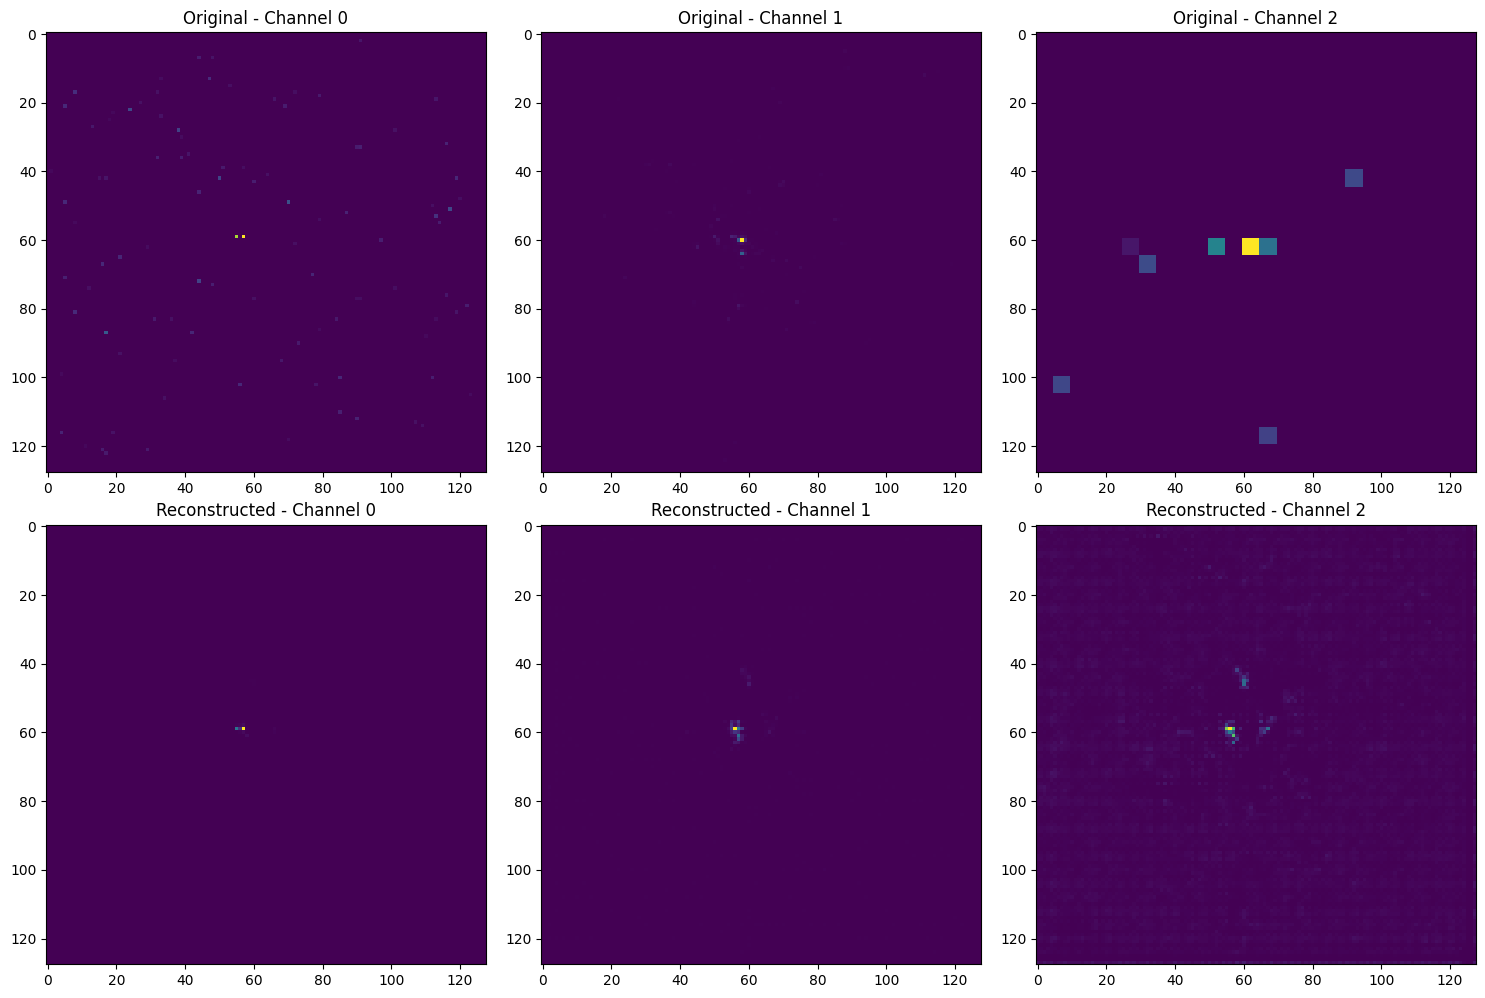

In [8]:
import torch
import random
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

model = VAE(latent_dim).to(device)
model.load_state_dict(torch.load("model.pth"))
model.eval()

#Select random image
r = random.randint(0, len(test_dataset) - 1)
imgorig = test_dataset[r].to(device)

recon_batch, mu, log_var = model(imgorig.unsqueeze(0))

loss, recon_loss, kl_loss = loss_function(recon_batch, imgorig.unsqueeze(0), mu, log_var)
print(f"Reconstruction Loss: {recon_loss.item():.6f}, KL Loss: {kl_loss.item():.6f}, Total Loss: {loss.item():.6f}")

pltorig = imgorig.permute(1, 2, 0).detach().cpu().numpy()  # (H, W, C)
pltrecons = recon_batch.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # (H, W, C)

#Plot original & reconstructed image for all channels
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(3):
    axs[0, i].imshow(pltorig[:, :, i], cmap="viridis")  # Original
    axs[0, i].set_title(f'Original - Channel {i}')
    
    axs[1, i].imshow(pltrecons[:, :, i], cmap="viridis")  # Reconstructed
    axs[1, i].set_title(f'Reconstructed - Channel {i}')

plt.tight_layout()
plt.show()
